In [1]:
import cv2
import numpy as np
import os
import sys
from samples import coco
from mrcnn import utils
from mrcnn import model as modellib

Using TensorFlow backend.


# Prepare Model File and Configuration Information

Now load the pre-trained model data (Mask-RCNN trained by COCO dataset).

In [2]:
# Load the pre-trained model data
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

The original configuration information is saved in config.py file. It can be changed if necessary. 

It's better to use the default value, but you can also change the GPU information to suit the personal GPU well.

In [3]:
# Change the config infermation
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    
    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()

In [4]:
# COCO dataset object names
model = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
model.load_weights(COCO_MODEL_PATH, by_name=True)
class_names = [
    'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

# Define The Image Process Function

Now define two image process functions to process each frame of the input video. 

apply_mask is used to change the background information to grayscale.

display_instances is used to show the object detection result in original image.

In [5]:
# This function is used to change the colorful background information to grayscale.
# image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
# mask == 0 means that this pixel is not belong to the object.
# np.where function means that if the pixel belong to background, change it to gray_image.
# Since the gray_image is 2D, for each pixel in background, we should set 3 channels to the same value to keep the grayscale.

def apply_mask(image, mask, back_image):
    image[:, :, 0] = np.where(
        mask == 0,
        back_image[:, :,0],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        back_image[:, :,1],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        back_image[:, :,2],
        image[:, :, 2]
    )
    return image

In [6]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores, back_image):
    # max_area will save the largest object for all the detection results
    max_area = 0
    
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
    main_box = 0
    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                main_box = boxes[i]
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

        # apply mask for the image
    # by mistake you put apply_mask inside for loop or you can write continue in if also
    image = apply_mask(image, mask, back_image)
#     y1, x1, y2, x2 = main_box
#     cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
    return image

# Process Video

Now use the functions above to accomplish the video processing and save the result.

In [7]:
import matplotlib.pyplot as plt
def plt_imshow(temp_img,cmap=None):
    fig=plt.figure(figsize=(10, 10), dpi= 80, edgecolor='k')
    plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB),cmap= cmap)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq

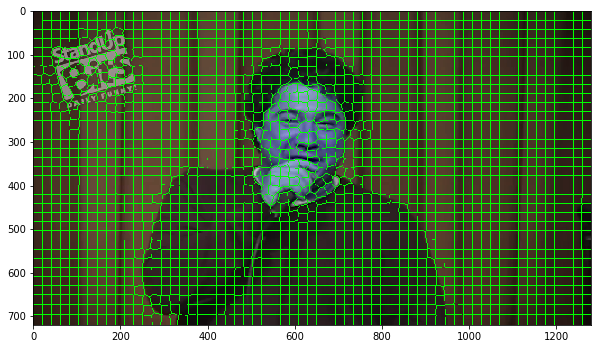

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


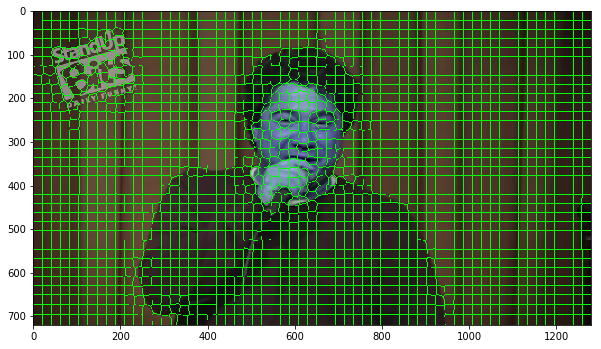

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


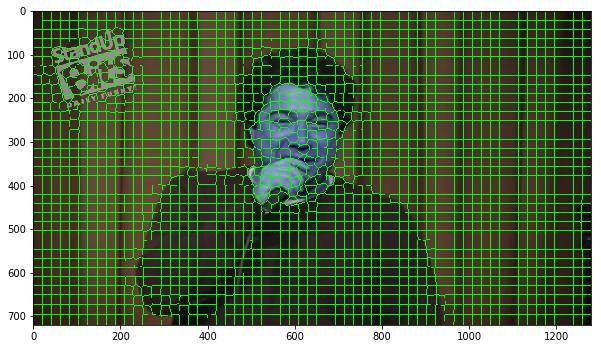

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


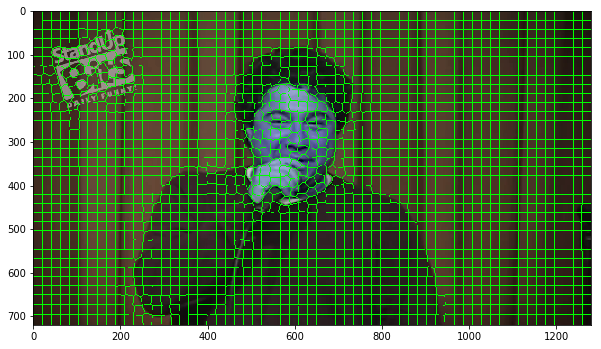

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


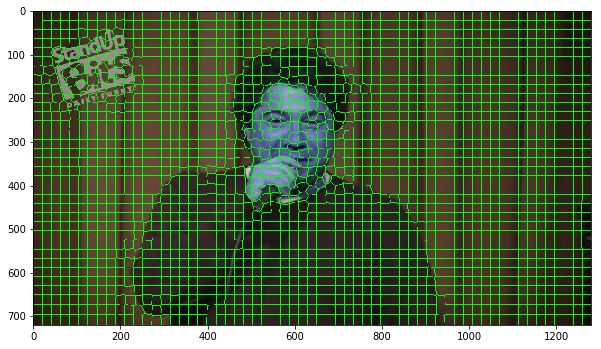

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


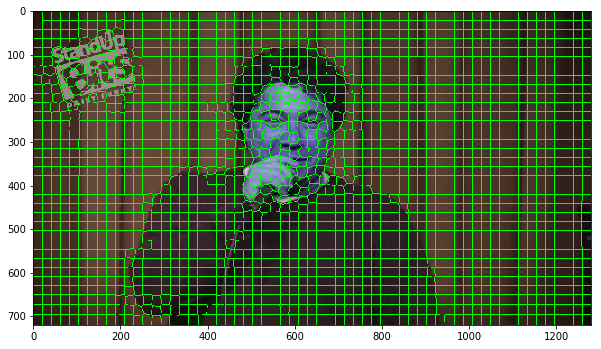

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


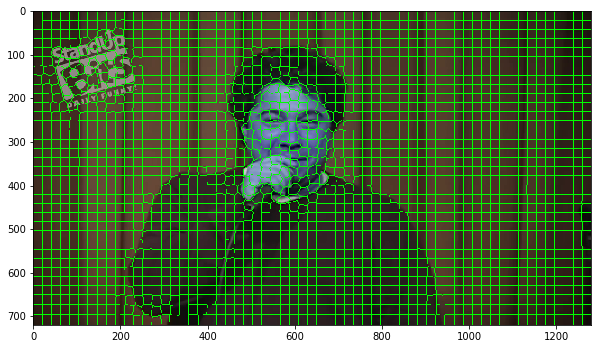

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


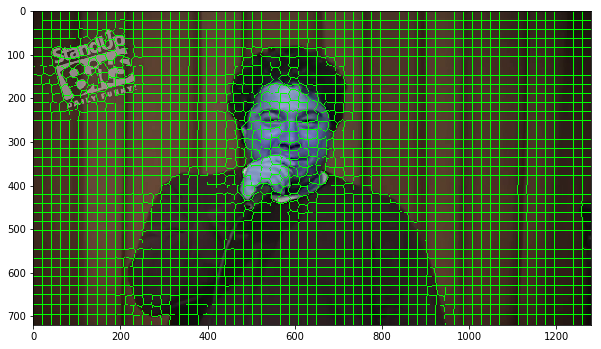

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


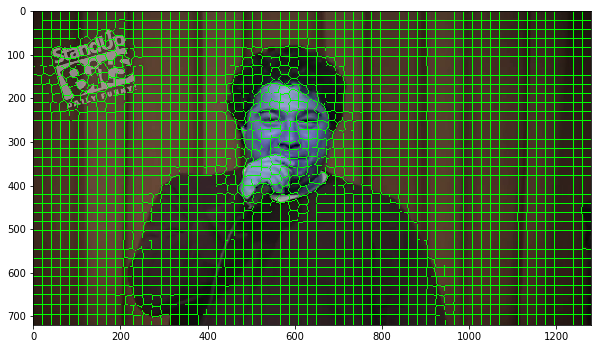

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


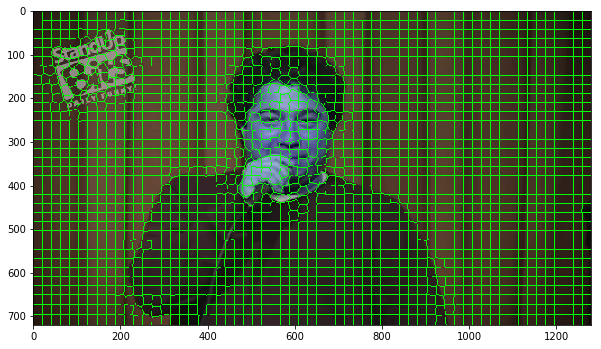

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


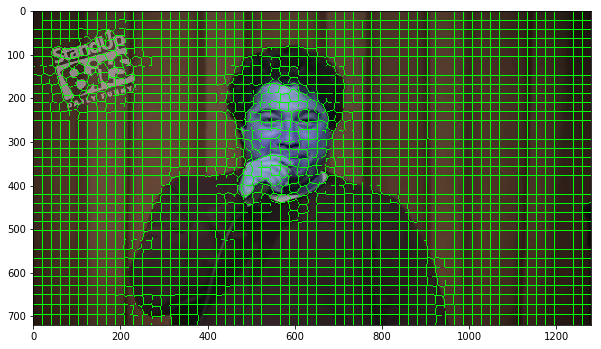

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


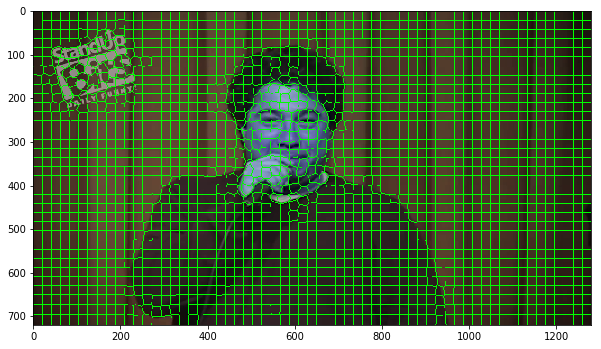

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


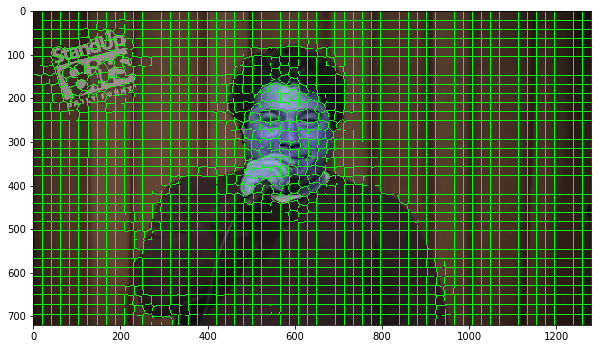

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


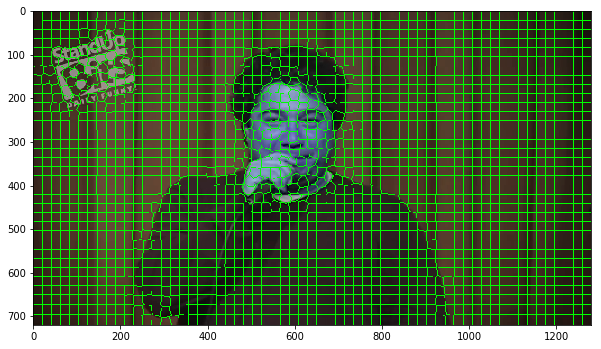

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


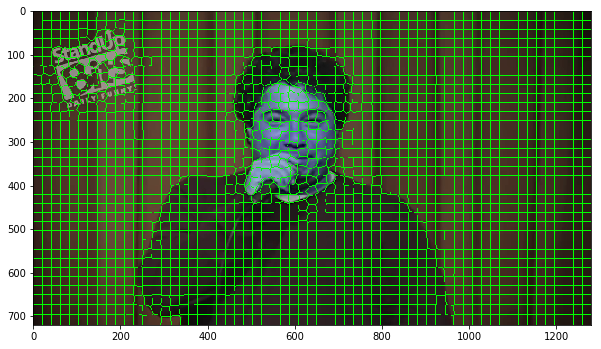

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


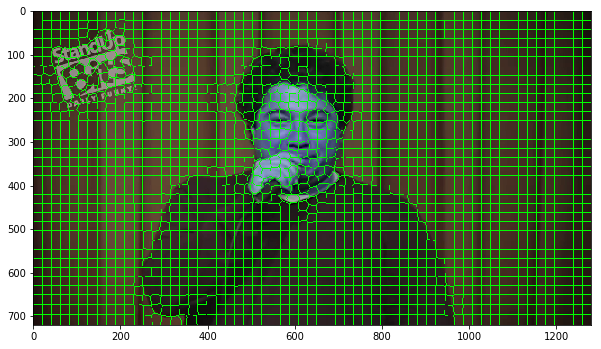

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


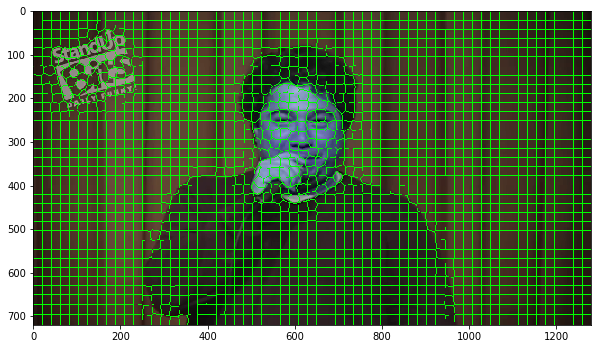

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


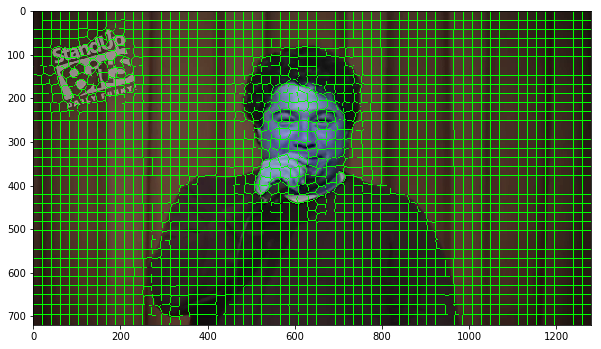

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


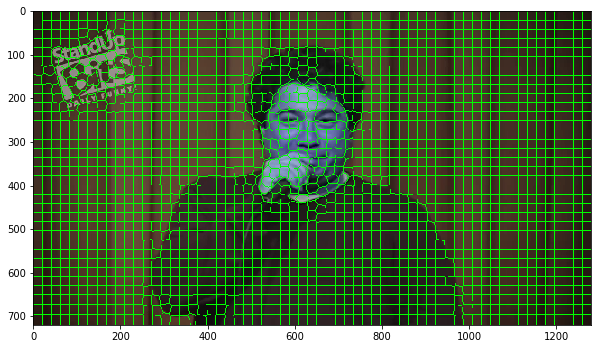

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


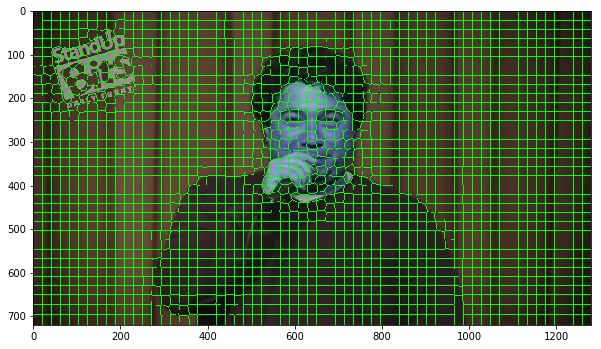

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


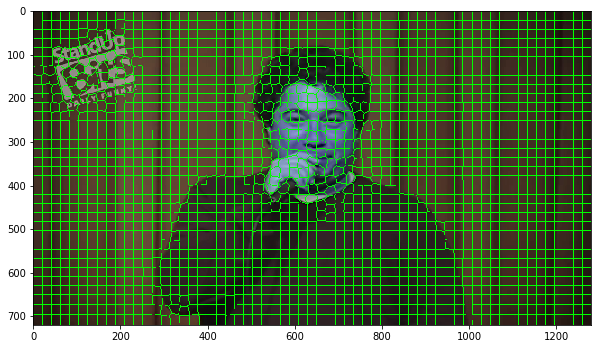

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


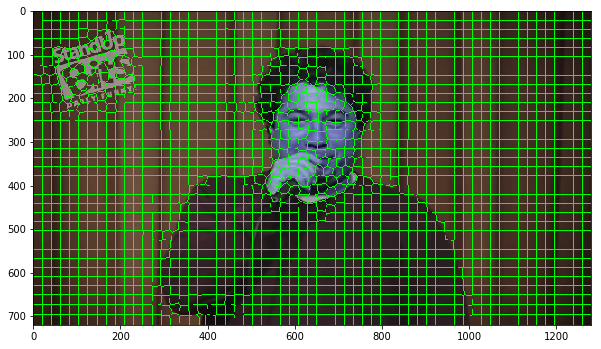

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


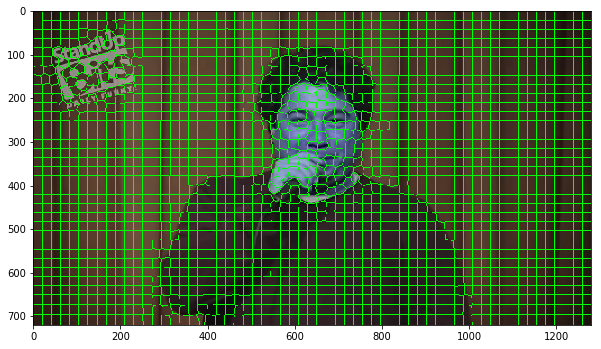

(720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
input_video = 'temp/1.mp4'
capture = cv2.VideoCapture(input_video)

# these 2 lines can be removed if you dont have a 1080p camera.
# capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
# capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)



import time
t1 = time.time()
# Recording Video
fps = 25.0
width = int(capture.get(3))
height = int(capture.get(4))
length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
fcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
out = cv2.VideoWriter("new_video_mesh.avi", fcc, fps, (width, height))
i = 0

ret,image = capture.read()
back_img = cv2.imread("back.jpeg")
back_img = cv2.resize(back_img, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
back_img = cv2.blur(back_img,(15,15))
from skimage.segmentation import slic, mark_boundaries
result = None
while True:
    ret, frame = capture.read()
    segments = slic(frame, n_segments=2000, compactness=25.0, 
                max_iter=10, sigma=5, spacing=None, multichannel=True, 
                convert2lab=True, enforce_connectivity=False, 
                min_size_factor=10, max_size_factor=30, slic_zero=False)
    boundaries = mark_boundaries(frame, segments, color=(0,255,0))
    plt.figure(figsize=(10,10))
    plt.imshow(boundaries)
    plt.show()
    print(boundaries.shape)
#     out.write(boundaries)
    if(i>length-2):
        break
t2 = time.time()
print(t2-t1,i,length)

![](save_sample.jpg)

In [19]:
290/30

9.666666666666666

ValueError: not enough values to unpack (expected 3, got 2)